# Herron Topic 7 - Five Stylized Facts of Asset Returns

[Rama Cont (2001)](https://www.tandfonline.com/doi/abs/10.1080/713665670) provides five stylized facts of asset returns, which we will investigate with the daily market factor data from the French Data Library.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import requests_cache
session = requests_cache.CachedSession()
import yfinance as yf
import pandas_datareader as pdr

## Returns are *not* normally distributed

Daily stock returns are not normally distributed (i.e., are non-Gaussian).
Daily stock returns have:

1. negative skewness (large negative returns occur more often than large positive ones)
1. excess kurtosis (large magnitude returns, positive or negative, occur more often than if returns were normally distributed)

We can show the non-normality of daily stock returns in at least two ways:

1. descriptive statistics (also known as summary statistics)
1. histograms

### Log and Simple Returns

We will use log returns to explore this first stylized fact only.
Simple returns cannot be less than -100%, so simple returns cannot be normally distributed.
However, log returns can approach positive and negative infinity.
Note that `np.log1p(X)` is equivalent to `np.log(1 + X)`.

In [4]:
mkt = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900',
        session=session
    )
    [0]
    .assign(
        R=lambda x: (x['Mkt-RF'] + x['RF']) / 100,
        logR=lambda x: np.log1p(x['R'])
    )
    [['R', 'logR']]
)

In [5]:
mkt

,R,logR
Date,,
1926-07-01,0.0011,0.0011
1926-07-02,0.0046,0.0046
1926-07-06,0.0018,0.0018
1926-07-07,0.0010,0.0010
1926-07-08,0.0022,0.0022
...,...,...
2022-12-23,0.0053,0.0052
2022-12-27,-0.0049,-0.0050
2022-12-28,-0.0121,-0.0122


In [6]:
labels = {
    'R': 'Simple Return',
    'logR': 'Log Return'
}

In [7]:
mkt.rename(columns=labels).corr()

,Simple Return,Log Return
Simple Return,1.0000,0.9997
Log Return,0.9997,1.0000


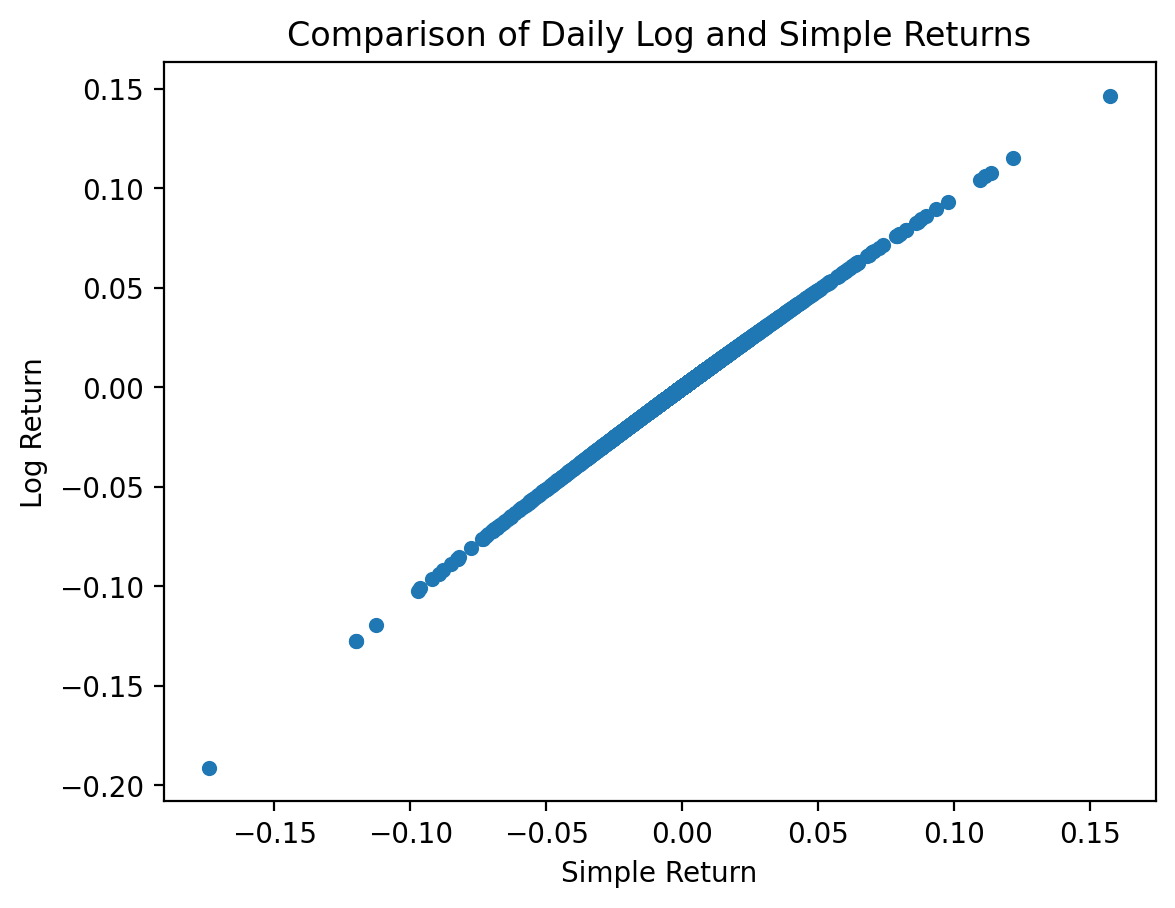

In [8]:
mkt.plot(x='R', y='logR', kind='scatter')
plt.title('Comparison of Daily Log and Simple Returns')
plt.xlabel(labels['R'])
plt.ylabel(labels['logR'])
plt.show()

### Summary statistics

The `.describe()` method reports mean and standard deviation (the first and second moments of the distribution) but does not report skewness and kurtosis (the third and fourth moments).
However, we can use the `.skew()` and `.kurt()` methods.

In [9]:
mkt.rename(columns=labels).describe()

,Simple Return,Log Return
count,25399.0000,25399.0000
mean,0.0004,0.0004
std,0.0108,0.0108
min,-0.1741,-0.1913
25%,-0.0039,-0.0039
50%,0.0008,0.0007
75%,0.0051,0.0051
max,0.1576,0.1464


In [10]:
print(f'Skewness:        {mkt["logR"].skew():.2f}')
print(f'Excess Kurtosis: {mkt["logR"].kurt():.2f}')

Skewness:        -0.47
Excess Kurtosis: 17.32


Both values are zero for the normal distribution.
Kurtosis is three for the normal distribution.
However, the `.kurt()` method reports *excess* kurtosis, which is kurtosis minus three.

### Histograms and density plots

Histograms provide another way to see the skewness and kurtosis of daily stock returns.
We can overlay a normal distribution with the same mean and standard deviation to highlight negative skewness and excess kurtosis.

In [11]:
import scipy.stats as scs

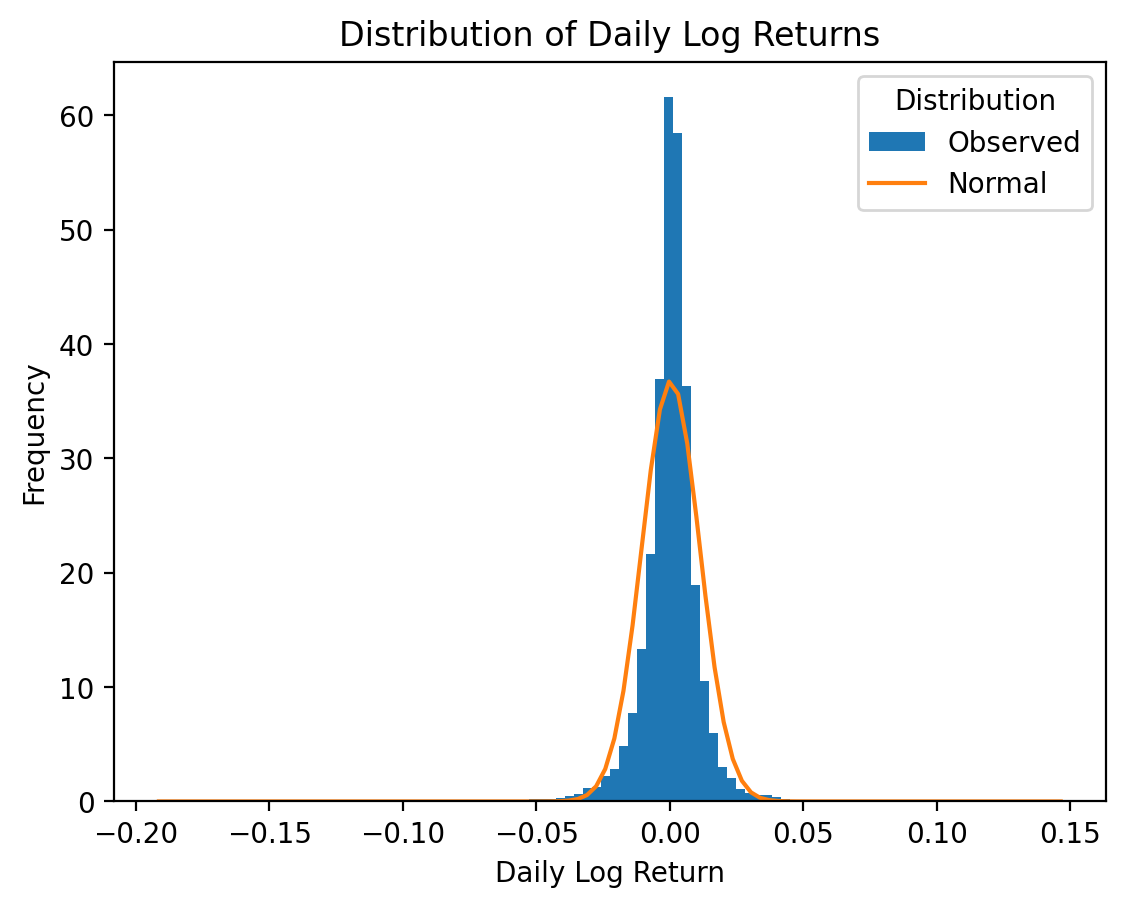

In [12]:
mkt['logR'].plot(kind='hist', bins=100, density=True, label='Observed')
xs = np.linspace(mkt['logR'].min(), mkt['logR'].max(), 100)
ys = scs.norm.pdf(x=xs, loc=mkt['logR'].mean(), scale=mkt['logR'].std())
plt.plot(xs, ys, label='Normal')
plt.xlabel('Daily Log Return')
plt.title('Distribution of Daily Log Returns')
plt.legend(title='Distribution')
plt.show()

If we zoom in, we can see that returns in the left tail (large magnitude negative returns) are much more likely than if they were normally distributed.

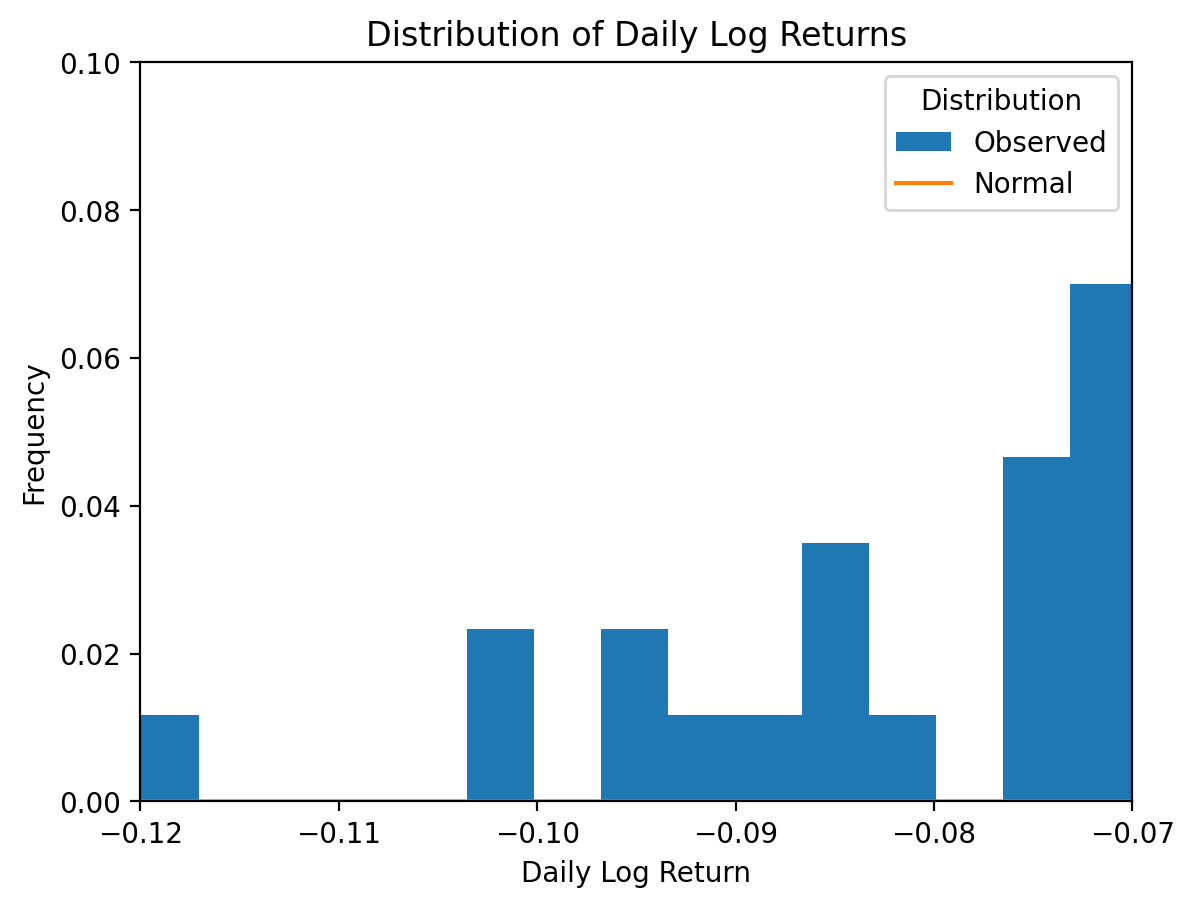

In [13]:
mkt['logR'].plot(kind='hist', bins=100, density=True, label='Observed')
xs = np.linspace(mkt['logR'].min(), mkt['logR'].max(), 100)
ys = scs.norm.pdf(x=xs, loc=mkt['logR'].mean(), scale=mkt['logR'].std())
plt.plot(xs, ys, label='Normal')
plt.xlabel('Daily Log Return')
plt.title('Distribution of Daily Log Returns')
plt.legend(title='Distribution')
plt.xlim([-0.12, -0.07])
plt.ylim([0, 0.1])
plt.show()

## Return volatility clusters in time

Stock return volatility varies over time, with alternating periods of low and high volatility.
We can visualize volatility clustering by plotting the time series of returns and volatility.
To reduce noise, we can plot the monthly means and standard deviations of daily returns.

In [14]:
def totret(x):
    return (1 + x).prod() - 1

In [15]:
mkt_m = (
    mkt['R']
    .resample(rule='M', kind='period') # kind='period' gives dates in year-months instead of year-month-days
    .agg([totret, 'std'])
)

In [17]:
mkt_m.head()

,totret,std
Date,,
1926-07,0.0312,0.0045
1926-08,0.0294,0.0059
1926-09,0.0059,0.0050
1926-10,-0.0299,0.0084
1926-11,0.0290,0.0038


In the top panel, we see that there are alternating periods of low magnitude and high magnitude mean daily returns.
In the bottom panel, we see that there are alternating periods of low and high volatility.

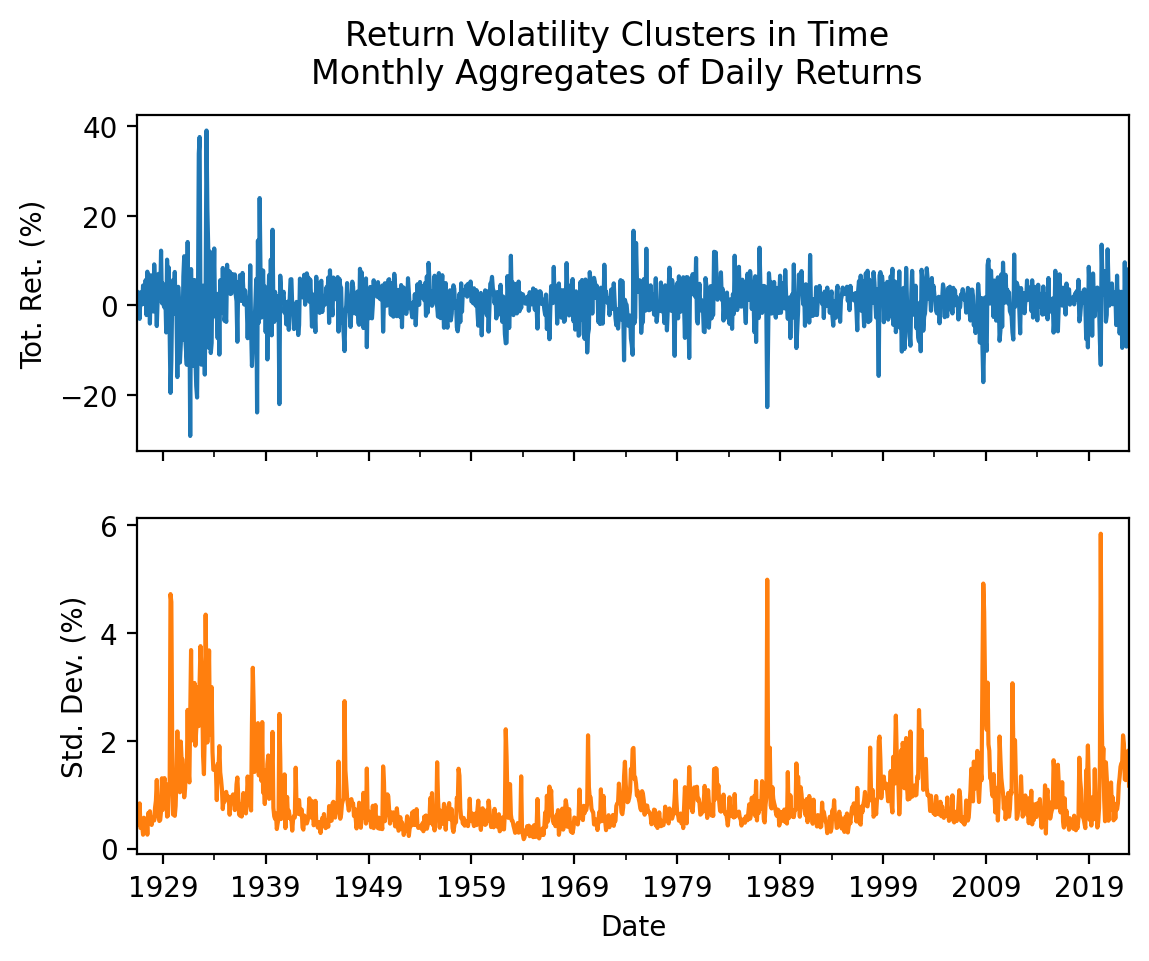

In [18]:
axes = mkt_m.mul(100).plot(subplots=True, legend=False)
axes[0].set_ylabel('Tot. Ret. (%)')
axes[1].set_ylabel('Std. Dev. (%)')
plt.suptitle(
    'Return Volatility Clusters in Time' + 
    '\nMonthly Aggregates of Daily Returns'
)
plt.show()

## Returns are *not* autocorrelated

***Stock returns today do not predict stock returns tomorrow.***
Stock returns are *not* autocorrelated, and stock returns on one day are not correlated with stock returns on previous days.
Therefore, we cannot predict future returns with past returns.
We can show this with an autocorrelation plot of daily stock returns (autocorrelation and serial correlation are synonyms).
The height of each line indicates the correlation coefficient ($\rho$) between returns on day 0 and lag $t$ (i.e., day $0 - t$).

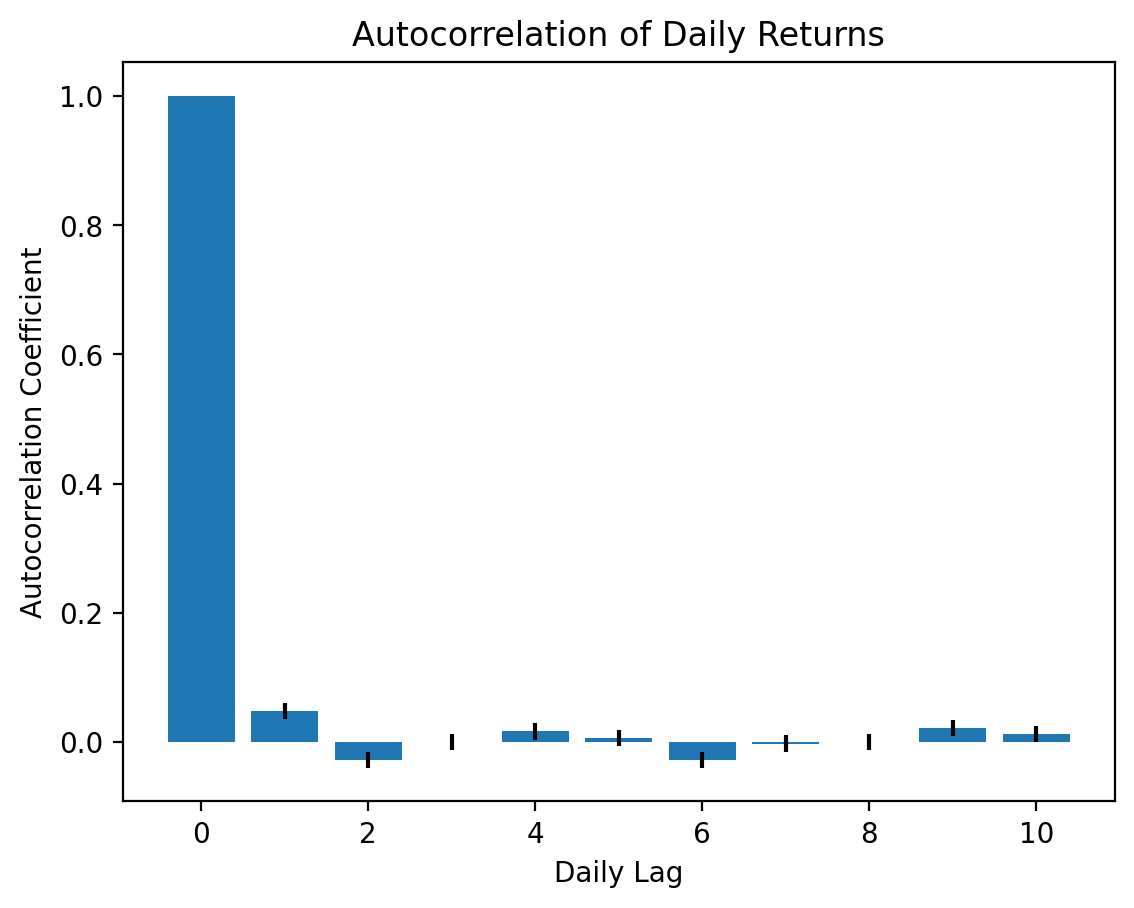

In [19]:
N = 10
mkt_lags = pd.concat(objs=[mkt['R'].shift(t) for t in range(N + 1)], axis=1)
corrs = mkt_lags.corr().iloc[0]
serrs = np.sqrt((1 - corrs**2) / (mkt_lags.count() - 2))

plt.bar(height=corrs, x=range(N + 1), yerr=2*serrs)
plt.title('Autocorrelation of Daily Returns')
plt.xlabel('Daily Lag')
plt.ylabel('Autocorrelation Coefficient')
plt.show()

Above, we see small autocorrelations at lags 1 and 2, suggesting some return predictability.
However, the magnitudes are small and disappear in monthly data.

As a side note, if we plot autocorrelations for a single security instead of the market, we typically find weak, negative autocorrelations for the 1-day lags.
However, this is due to bid-ask bounce.
About half the time, positive returns follow negative returns (and *vice versa*) if closing prices randomly alternate between the bid and ask without changes in true prices.

## *Squared* returns *are* autocorrelated with slowly decaying autocorrelation

Because volatility clusters in time, squared stock returns (and the absolute values of stock returns) are autocorrelated.

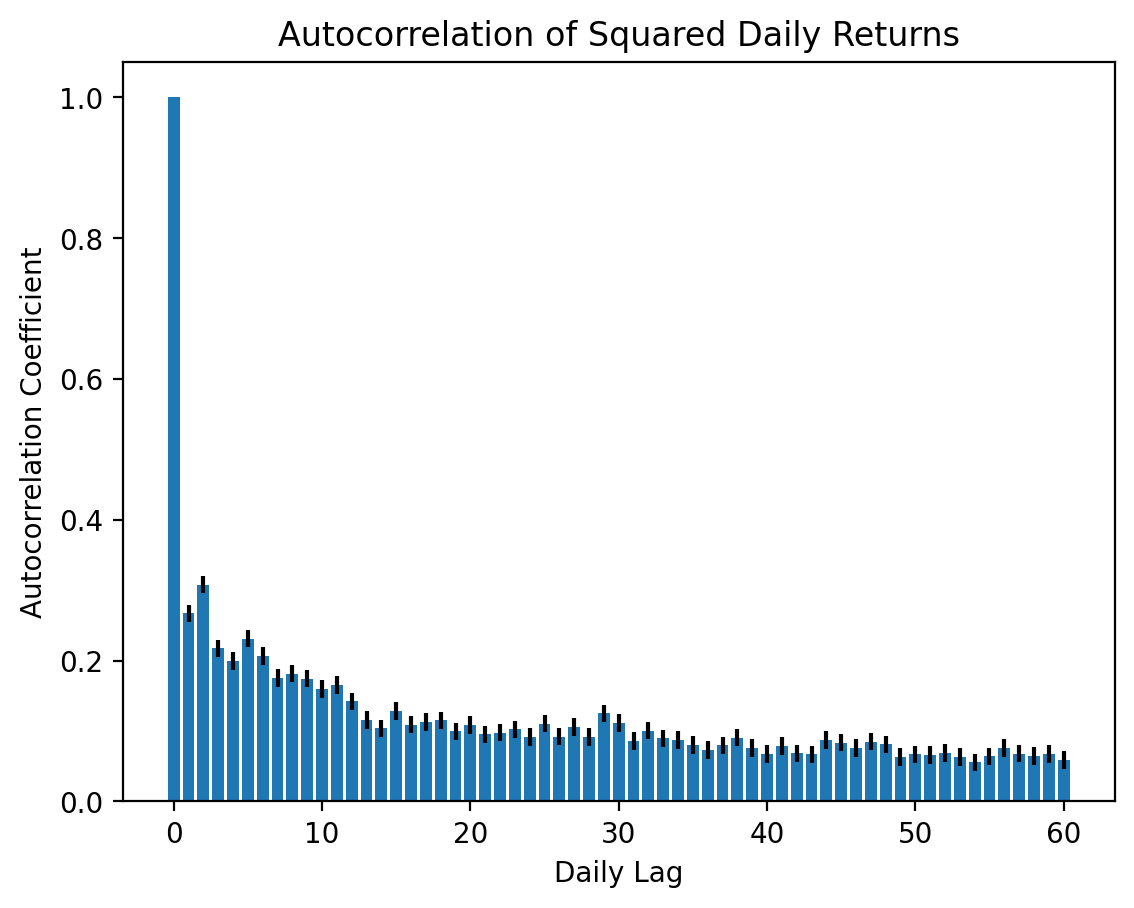

In [20]:
N = 60
mkt_lags = pd.concat(objs=[mkt['R'].shift(t) for t in range(N + 1)], axis=1)
corrs = (mkt_lags ** 2).corr().iloc[0]
serrs = np.sqrt((1 - corrs**2) / (mkt_lags.count() - 2))

plt.bar(height=corrs, x=range(N + 1), yerr=2*serrs)
plt.title('Autocorrelation of Squared Daily Returns')
plt.xlabel('Daily Lag')
plt.ylabel('Autocorrelation Coefficient')
plt.show()

## Fisher Black's leverage effect - volatility and returns are negatively related

> One of the most enduring empirical regularities in equity markets is the inverse relationship between stock prices and volatility, first documented by Black (1976) who attributed it to the effects of financial leverage. As a company's stock price declines, it becomes more highly leveraged given a fixed level of debt outstanding, and this increase in leverage induces a higher equity-return volatility... [(Hasanhodzic and Lo, 2011)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1762363)

We can visualize the leverage effect by plotting the monthly mean and standard deviation of daily returns.
We typically want to report *annualized* mean and volatility of returns (i.e., multiply the mean and volatility of daily returns by 252 and $\sqrt{252}$).
However, we will plot daily values here  because some annualized values would be very large when we estimate means and volatilities using only one month of data.

In [21]:
mkt_m = (
    mkt['R']
    .resample(rule='M', kind='period')
    .agg([totret, 'std'])
)

In [22]:
import seaborn as sns

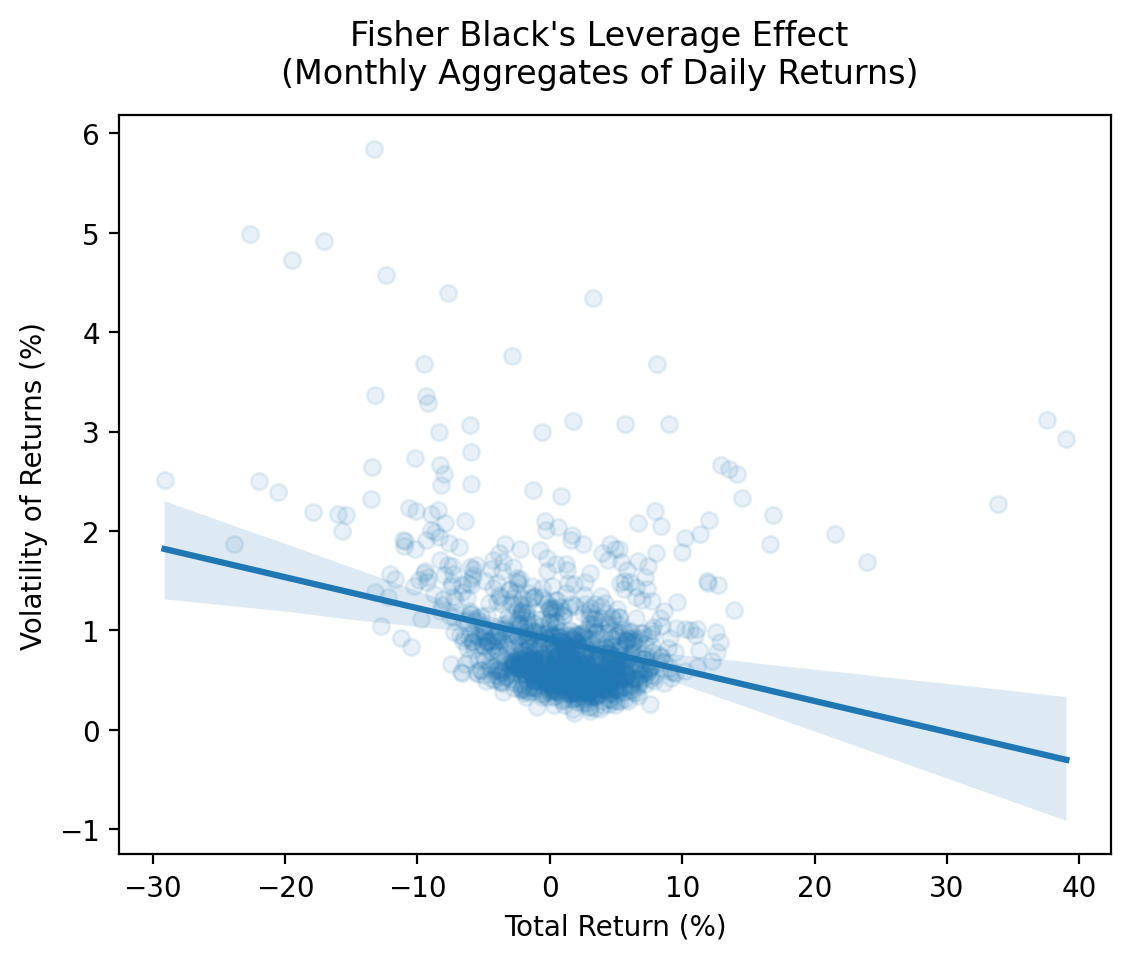

In [23]:
sns.regplot(
    x='totret',
    y='std',
    data=mkt_m.mul(100),
    scatter_kws={'alpha': 0.1}
)
plt.xlabel('Total Return (%)')
plt.ylabel('Volatility of Returns (%)')
plt.suptitle(
    'Fisher Black\'s Leverage Effect\n' + 
    '(Monthly Aggregates of Daily Returns)'
)
plt.show()

## Conclusion

Financial data analysts should know that real data do not exactly behave as we learn in finance 101.

1. Stock returns are non-Gaussian (not normally distributed) with:
    1. Negative skew
    1. Excess kurtosis
1. Stock return volatility clusters in time
1. Stock returns are *not* autocorrelated
1. *However,* squared stock returns *are* autocorrelated
1. Stock volatility and stock returns are inversely related